# EEG Model Training Notebook

This notebook contains the model training pipeline used for EEG classification. An overview of this notebook is as follows

1. Training/Testing dataset creation with eeg features
2. Simple Classifier
3. Overall Results

In [1]:
# import some useful libraries

import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from scipy import signal


# model creation
import torch.nn as nn
import torch.nn.functional as F
import torch

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold

# loading bar
from tqdm import tqdm


/home/bkat/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training/Testing dataset creation

Before we create the models, we will first prepare the data by splitting it and preprocessing it.

In [2]:
eeg_feeltrace_dir = 'ALIGNED_DATA' # directory containing *.csv files
# hyper parameters
window_size = 500 # must be an int in milliseconds
subject_num = 10 # which subject to choose [1-16]
k_fold = 5 # k for k fold validation
label_type = 'accumulator' # 'angle' or 'pos' or 'both'
num_classes = 3 if label_type != 'both' else 9 # number of classes to discretize the labels into
num_features = 64 # eeg feature size
classifier_learning_rate = 1e-3 # adam learning rate
classifier_train_epochs = 10 # train classifier duration
classifier_hidden = 8 # classifier parameter, the larger the more complicated the model

In [3]:
# functions for preprocessing dataset
# the data is stored in an Nx66 matrix. The first column is time in milliseconds, the second is the min/max normalized feel trace ([0,1])
# the other 64 entries are the eeg channels

def load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, subject_num = 5, k=5, label_type='angle', num_classes=3):
    # choose the subject
    subject_data_files = glob.glob(os.path.join(eeg_ft_dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.csv')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    eeg_ft = subject_data_files[subject_num-1]

    print(f"Chosen subject: {eeg_ft}")
    
    input_label_pair = pd.read_csv(eeg_ft).values # read the Nx66 data for a single subject

    x = ( input_label_pair[:,2:] - input_label_pair[:,2:].min(axis=0, keepdims=True) )
    y = ( input_label_pair[:,2:].max(axis=0, keepdims=True) -  input_label_pair[:,2:].min(axis=0, keepdims=True) )
    input_label_pair[:,2:] = x/y # eeg-channel-wise min/max normalization

    dataset = [input_label_pair[x : x + split_size] for x in range(0, len(input_label_pair), split_size)] # split into windows here
    if len(dataset[-1]) < split_size:
        dataset.pop() # remove last window if it is smaller than the rest

    if label_type != 'both':
        labels = get_label(dataset, n_labels=num_classes, label_type=label_type).squeeze() # (N, 1)
    else:
        labels = get_combined_label(dataset, n_labels=int(np.sqrt(num_classes))).squeeze() # (N, 1)

    tmp = dataset
    # generate features from eeg signal
    dataset = generate_eeg_features(dataset, split_size=split_size)
    dataset = np.vstack([np.expand_dims(x,0) for x in dataset]) # (N, eeg_feature_size, 64)
    print(f"Time + Feel trace + Channel set shape (N, eeg_feature_size, 64):  {dataset.shape}")
    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k) # split data into train/test indices using kFold validation
    return dataset, labels, indices, tmp


def get_label(data, n_labels=3, label_type='angle'):
    if label_type == 'angle':
        labels = stress_2_angle(np.vstack([x[:,1].T for x in data])) # angle/slope mapped to [0,1] in a time window
    elif label_type == 'pos':
        labels = np.vstack([x[:,1].mean() for x in data]) # mean value within the time window
    else:
        labels = stress_2_accumulator(np.vstack([x[:,1].T for x in data])) # accumulator mapped to [0,1] in a time window
        
    label_dist = stress_2_label(labels, n_labels=n_labels)
    return label_dist

def get_combined_label(data, n_labels=3):
    angle_labels = get_label(data, n_labels=n_labels, label_type='angle').squeeze() # (N, 1)
    pos_labels = get_label(data, n_labels=n_labels, label_type='pos').squeeze() # (N, 1)

    labels = [x for x in range(n_labels)]
    labels_dict =  {(a, b) : n_labels*a+b for a in labels for b in labels} # cartesian product
    combined_labels = [labels_dict[(pos, angle)] for (pos, angle) in zip(pos_labels, angle_labels)]
    return np.array(combined_labels)


def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

def stress_2_angle(stress_windows):
    '''
    do a linear least squares fit in the time window
    stress_window: (N_samples, time_window)
    '''
    xvals = np.arange(stress_windows.shape[-1])/1e3/60 # time in (minutes)
    slope = np.polyfit(xvals, stress_windows.T, 1)[0] # take slope linear term # 1/s
    angle = np.arctan(slope)/ (np.pi/2) * 0.5 + 0.5 # map to [0,1]
    return angle

def stress_2_accumulator(stress_windows):
    '''
    apply an integral to the time window
    stress_window: (N_samples, time_window)
    '''
    max_area = stress_windows.shape[-1]
    xvals = np.arange(stress_windows.shape[-1]) # time in (ms)
    integral = np.trapz(stress_windows, x=xvals)
    return integral/max_area # map to [0,1]

def split_dataset(labels, k=5):
    '''
    split the features and labels into k groups for k fold validation
    we use StratifiedKFold to ensure that the class distrubutions within each sample is the same as the global distrubution
    '''
    kf = StratifiedKFold(n_splits=k, shuffle=True)

    # only labels are required for generating the split indices so we ignore it
    temp_features = np.zeros_like(labels)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(temp_features, labels)]
    return indices

def generate_eeg_features(dataset, split_size=200):
    sample_freq = 1000
    # get FFT
    psd_windows = [signal.periodogram(x[:,2:], sample_freq, axis=0) for x in dataset ] # get the power spectral density for each window

    # frequency bands
    bands={'alpha': (8, 12), 'beta': (12, 30), 'delta': (1, 4), 'theta': (4, 7), 'gamma': (30, 50)}
    band_freqs = [bands[x] for x in ['alpha', 'beta', 'delta', 'theta', 'gamma']]

    features = []
    for window in psd_windows: # calculate the power in each band for channel for each window
        freqs, psd = window
        idx_bands = [np.logical_and(freqs >= low, freqs <= high) for low,high in band_freqs]

        freq_res = freqs[1] - freqs[0]
        band_powers = np.array([sp.integrate.simpson(psd[idx,:], dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        total_powers = np.array([sp.integrate.simpson(psd, dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        diff_entropy = -0.5 * np.log(band_powers/total_powers)
        # (5, 1, 64)
        # (5, 64, 1)
        diff_de = np.expand_dims(diff_entropy, axis=2) - np.expand_dims(diff_entropy, axis=1) # (5,64,64)
        diff_de = (diff_de  - diff_de.min(axis=(1,2), keepdims=True))/(diff_de.max(axis=(1,2), keepdims=True) - diff_de.min(axis=(1,2), keepdims=True))
        
        features.append(diff_de)
    return features

In [4]:
dataset, labels, indices, tmp = load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=window_size, subject_num = subject_num, k=k_fold, label_type=label_type, num_classes=num_classes)
print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")

Chosen subject: ALIGNED_DATA/EEG_FT_ALIGNED_9.csv
Time + Feel trace + Channel set shape (N, eeg_feature_size, 64):  (1323, 5, 64, 64)
label set shape (N,):  (1323,)
Label class bincount: [ 69 929 325]


In [5]:
# eeg = tmp[5][:,2:]
# fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, constrained_layout=True )
# ax.plot(np.arange(window_size)/1000, eeg)
# ax.set_aspect('auto')
# ax.grid(True)
# plt.show()

# freqs, psd = signal.periodogram(eeg, 1000, axis=0)

# print(psd.shape)

# fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, constrained_layout=True )
# ax.semilogy(freqs, psd, alpha=0.5)
# ax.set_xlim(0, 100)
# ax.set_aspect('auto')
# ax.grid(True)
# plt.show()

# bands={'alpha': (8, 12), 'beta': (12, 30), 'delta': (1, 4), 'theta': (4, 7), 'gamma': (30, 50)}
# band_freqs = [bands[x] for x in ['alpha', 'beta', 'delta', 'theta', 'gamma']]


# idx_bands = [np.logical_and(freqs >= low, freqs <= high) for low,high in band_freqs]
# freq_res = freqs[1] - freqs[0]

# band_powers = np.array([sp.integrate.simpson(psd[idx,:], dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
# total_powers = np.array([sp.integrate.simpson(psd, dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)


# diff_entropy = -0.5 * np.log(band_powers/total_powers)

# print(diff_entropy[0])

# fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, constrained_layout=True )
# ax.bar(x=np.arange(64), height=diff_entropy[2])
# ax.set_aspect('auto')
# ax.grid(True)
# plt.show()

# diff_de = np.expand_dims(diff_entropy, axis=2) - np.expand_dims(diff_entropy, axis=1) # (5,64,64)


# fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, constrained_layout=True )
# cax = ax.matshow(diff_de.T[:,:,2], cmap=plt.cm.RdBu)
# ax.set_aspect('auto')
# ax.grid(False)

# #fig.subplots_adjust(top=1.01)
# fig.colorbar(cax, fraction=0.4, pad=0.004)
# plt.show()


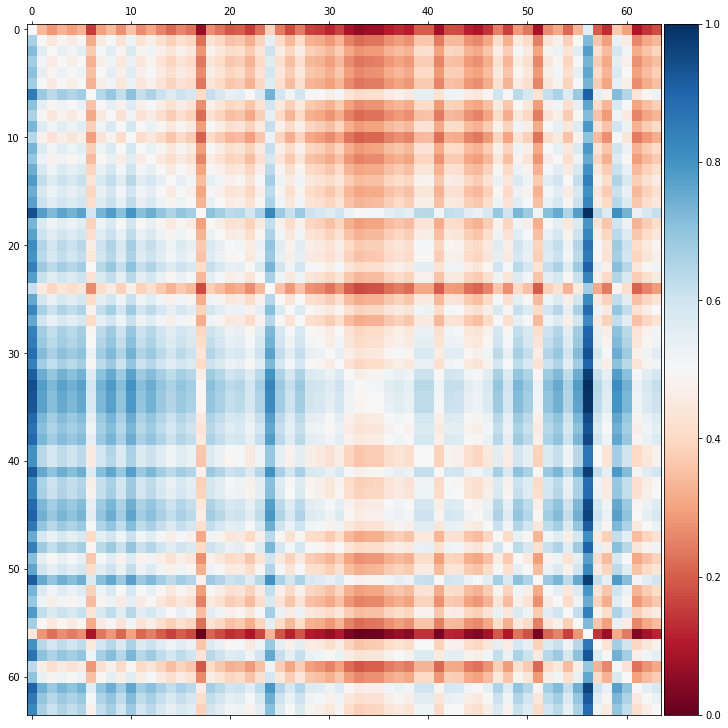

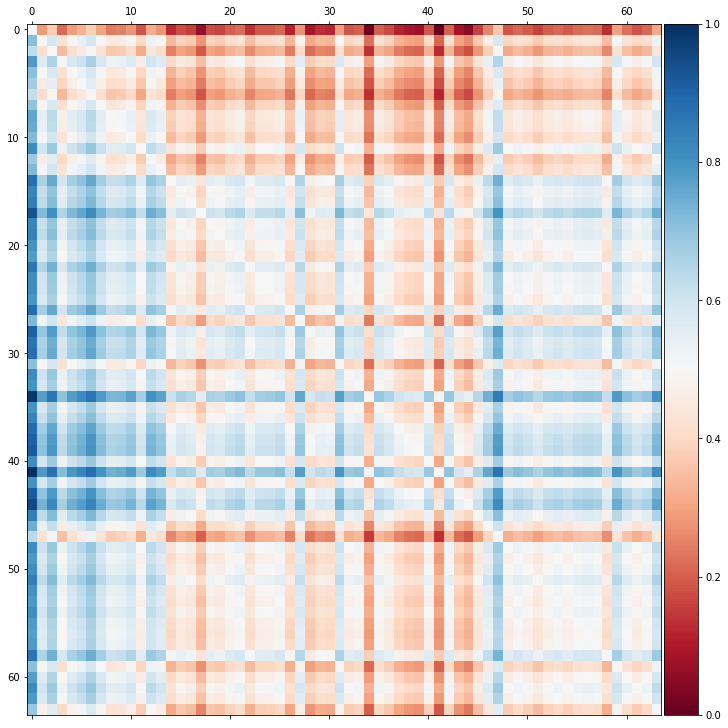

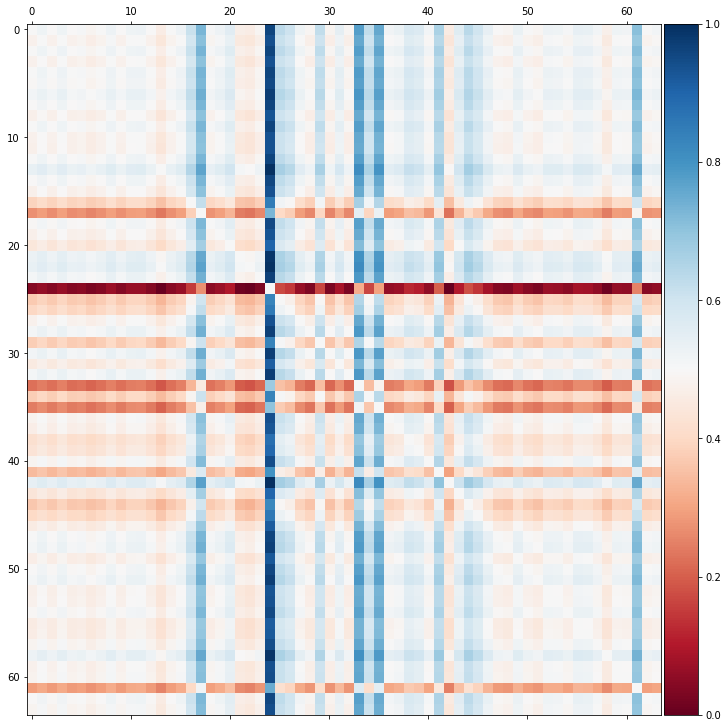

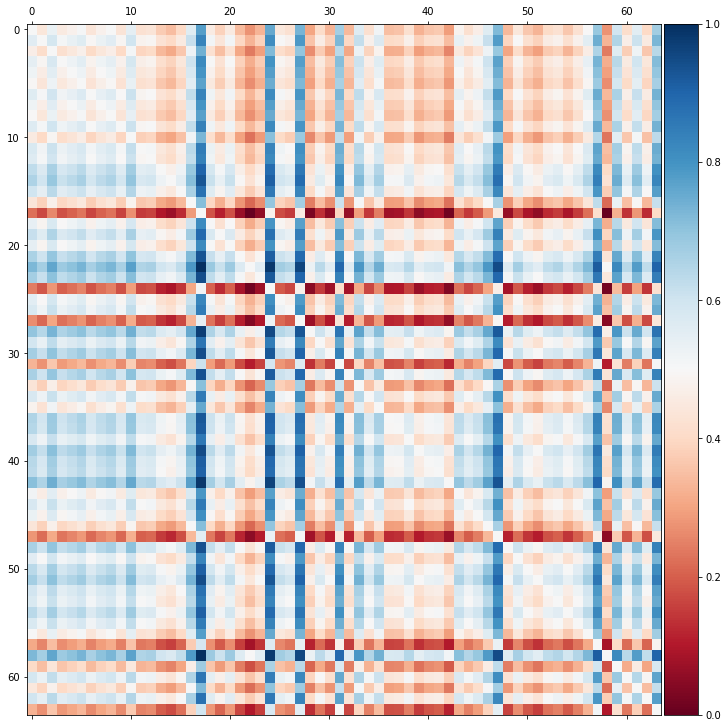

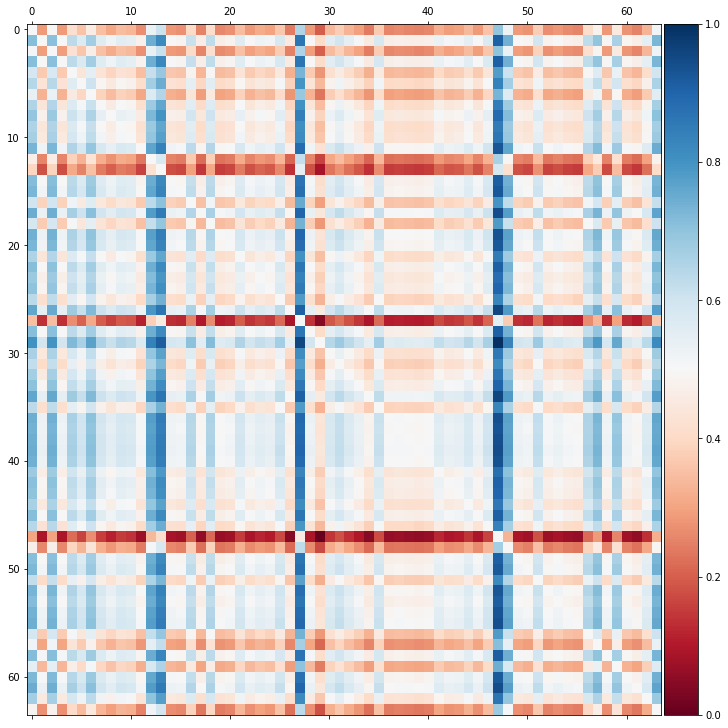

In [6]:
dataset[5].T.shape

for i in range(5):
    fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, constrained_layout=True )
    cax = ax.matshow(dataset[5].T[:,:,i], cmap=plt.cm.RdBu, vmin=0, vmax=1)
    ax.set_aspect('auto')
    ax.grid(False)

    #fig.subplots_adjust(top=1.01)
    fig.colorbar(cax, fraction=0.4, pad=0.004)
    plt.show()

## Models & Loader function
Below we define the autoencoder and lstm model

In [7]:
class classifier(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=5):
        super(classifier, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same'),
            nn.ReLU()
            # nn.Dropout2d(p=dropout),
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64 * 64 * 8, self.n_classes))
            # nn.ReLU(),
            # # nn.Dropout(p=dropout),
            # # nn.Linear(2*self.hidden_size, self.hidden_size),
            # # nn.ReLU(),
            # # nn.Dropout(p=dropout),
            # nn.Linear(self.hidden_size, self.n_classes))
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

In [8]:
class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        'Initialization'
        self.x = features # (N, eeg_feature_size, 64)
        self.labels = labels # (N, 1)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index]).float() # (eeg_feature_size, 64, 64)
        y = torch.from_numpy(np.array(self.labels[index])).long() # feel trace labels int value [0,n_labels]
        return x, y

## Training Loops

In [9]:

def train_classifier(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None,  label_smoothing=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_labels = labels
    
    # get the weights of each class as 1/occurrence
    train_class_weight = np.bincount(train_labels, minlength=num_classes)
    print(f"Train label distribution: {train_class_weight}")
    train_class_weight = 1/train_class_weight
    
    # get the per sample weight, which is the likelihood os sampling
    train_sample_weights = [train_class_weight[x] for x in train_labels]
    
    # sampler, weighted by the inverse of the occurrence
    train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)
    
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=train_sampler)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_acc = 0 # accuracy
        cur_train_pc = 0 # precision
        cur_train_rc = 0 # recall
        cur_train_f1 = 0 # f1
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,) # predictions
            y_np = y.detach().cpu().numpy().squeeze().reshape(-1,) # labels
            
            # metrics
            prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
            
            cur_train_acc += np.mean(y_hat_np == y_np)
            cur_train_pc += prf[0]
            cur_train_rc += prf[1]
            cur_train_f1 += prf[2]
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_acc  = cur_train_acc/train_loop_size
        cur_train_pc   = cur_train_pc/train_loop_size
        cur_train_rc   = cur_train_rc/train_loop_size
        cur_train_f1   = cur_train_f1/train_loop_size
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_acc, cur_train_pc, cur_train_rc, cur_train_f1, cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTrain Accuracy:{cur_train_acc},'\
              f'\nTrain Recall: {cur_train_rc},'\
              f'\nTrain precision: {cur_train_pc},' \
              f'\nTrain F1-Score:{cur_train_f1},')
        
    return train_metrics

#### Run Training for encoder and classifier (with encoding) and test classifier

Training k=0
Training Classifier!
Train label distribution: [ 55 743 260]


100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


Epoch:1,
Train Loss:1.637730598449707,
Train Accuracy:0.3421670751633987,
Train Recall: 0.3273016465513666,
Train precision: 0.13479514006202356,
Train F1-Score:0.18401518602707195,


100%|██████████| 9/9 [00:01<00:00,  5.22it/s]


Epoch:2,
Train Loss:1.201387882232666,
Train Accuracy:0.35753676470588236,
Train Recall: 0.3637426559929805,
Train precision: 0.2400268513806872,
Train F1-Score:0.2422067008489124,


100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


Epoch:3,
Train Loss:1.0835719108581543,
Train Accuracy:0.41339869281045755,
Train Recall: 0.4248657991797584,
Train precision: 0.3716833926624916,
Train F1-Score:0.3258904974465779,


100%|██████████| 9/9 [00:01<00:00,  5.46it/s]


Epoch:4,
Train Loss:1.0137717723846436,
Train Accuracy:0.5381944444444444,
Train Recall: 0.5338342777546329,
Train precision: 0.5478846505564026,
Train F1-Score:0.4889310817541803,


100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Epoch:5,
Train Loss:0.9386040568351746,
Train Accuracy:0.5877246732026143,
Train Recall: 0.5881371735144073,
Train precision: 0.6430454125802716,
Train F1-Score:0.5602535398632726,


100%|██████████| 9/9 [00:01<00:00,  5.40it/s]


Epoch:6,
Train Loss:0.8653558492660522,
Train Accuracy:0.6207107843137254,
Train Recall: 0.6136516922624797,
Train precision: 0.6251277948540345,
Train F1-Score:0.6019085003698889,


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


Epoch:7,
Train Loss:0.8509292602539062,
Train Accuracy:0.6389399509803921,
Train Recall: 0.6462076965164051,
Train precision: 0.6441357887690269,
Train F1-Score:0.6246269301562167,


100%|██████████| 9/9 [00:01<00:00,  5.08it/s]


Epoch:8,
Train Loss:0.8022307753562927,
Train Accuracy:0.6235702614379085,
Train Recall: 0.6146227951735042,
Train precision: 0.6301939452090858,
Train F1-Score:0.6054036713400814,


100%|██████████| 9/9 [00:01<00:00,  4.89it/s]


Epoch:9,
Train Loss:0.7638896107673645,
Train Accuracy:0.6798406862745098,
Train Recall: 0.6840033972737933,
Train precision: 0.6807953323566788,
Train F1-Score:0.6756569702188222,


100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


Epoch:10,
Train Loss:0.7802625298500061,
Train Accuracy:0.6717218137254902,
Train Recall: 0.6692227691625345,
Train precision: 0.6762542584013396,
Train F1-Score:0.6446485198316118,
Test label distribution: [ 14 186  65]
Precision: 0.5327998088867654
Recall: 0.5418567095986452
F1-Score: 0.45048160809030374
Base line F1-Score: 0.2749445676274945
Accuracy: 0.6113207547169811
Metrics:
              precision    recall  f1-score   support

           0       0.15      0.64      0.24        14
           1       0.75      0.74      0.74       186
           2       0.70      0.25      0.36        65

    accuracy                           0.61       265
   macro avg       0.53      0.54      0.45       265
weighted avg       0.71      0.61      0.62       265



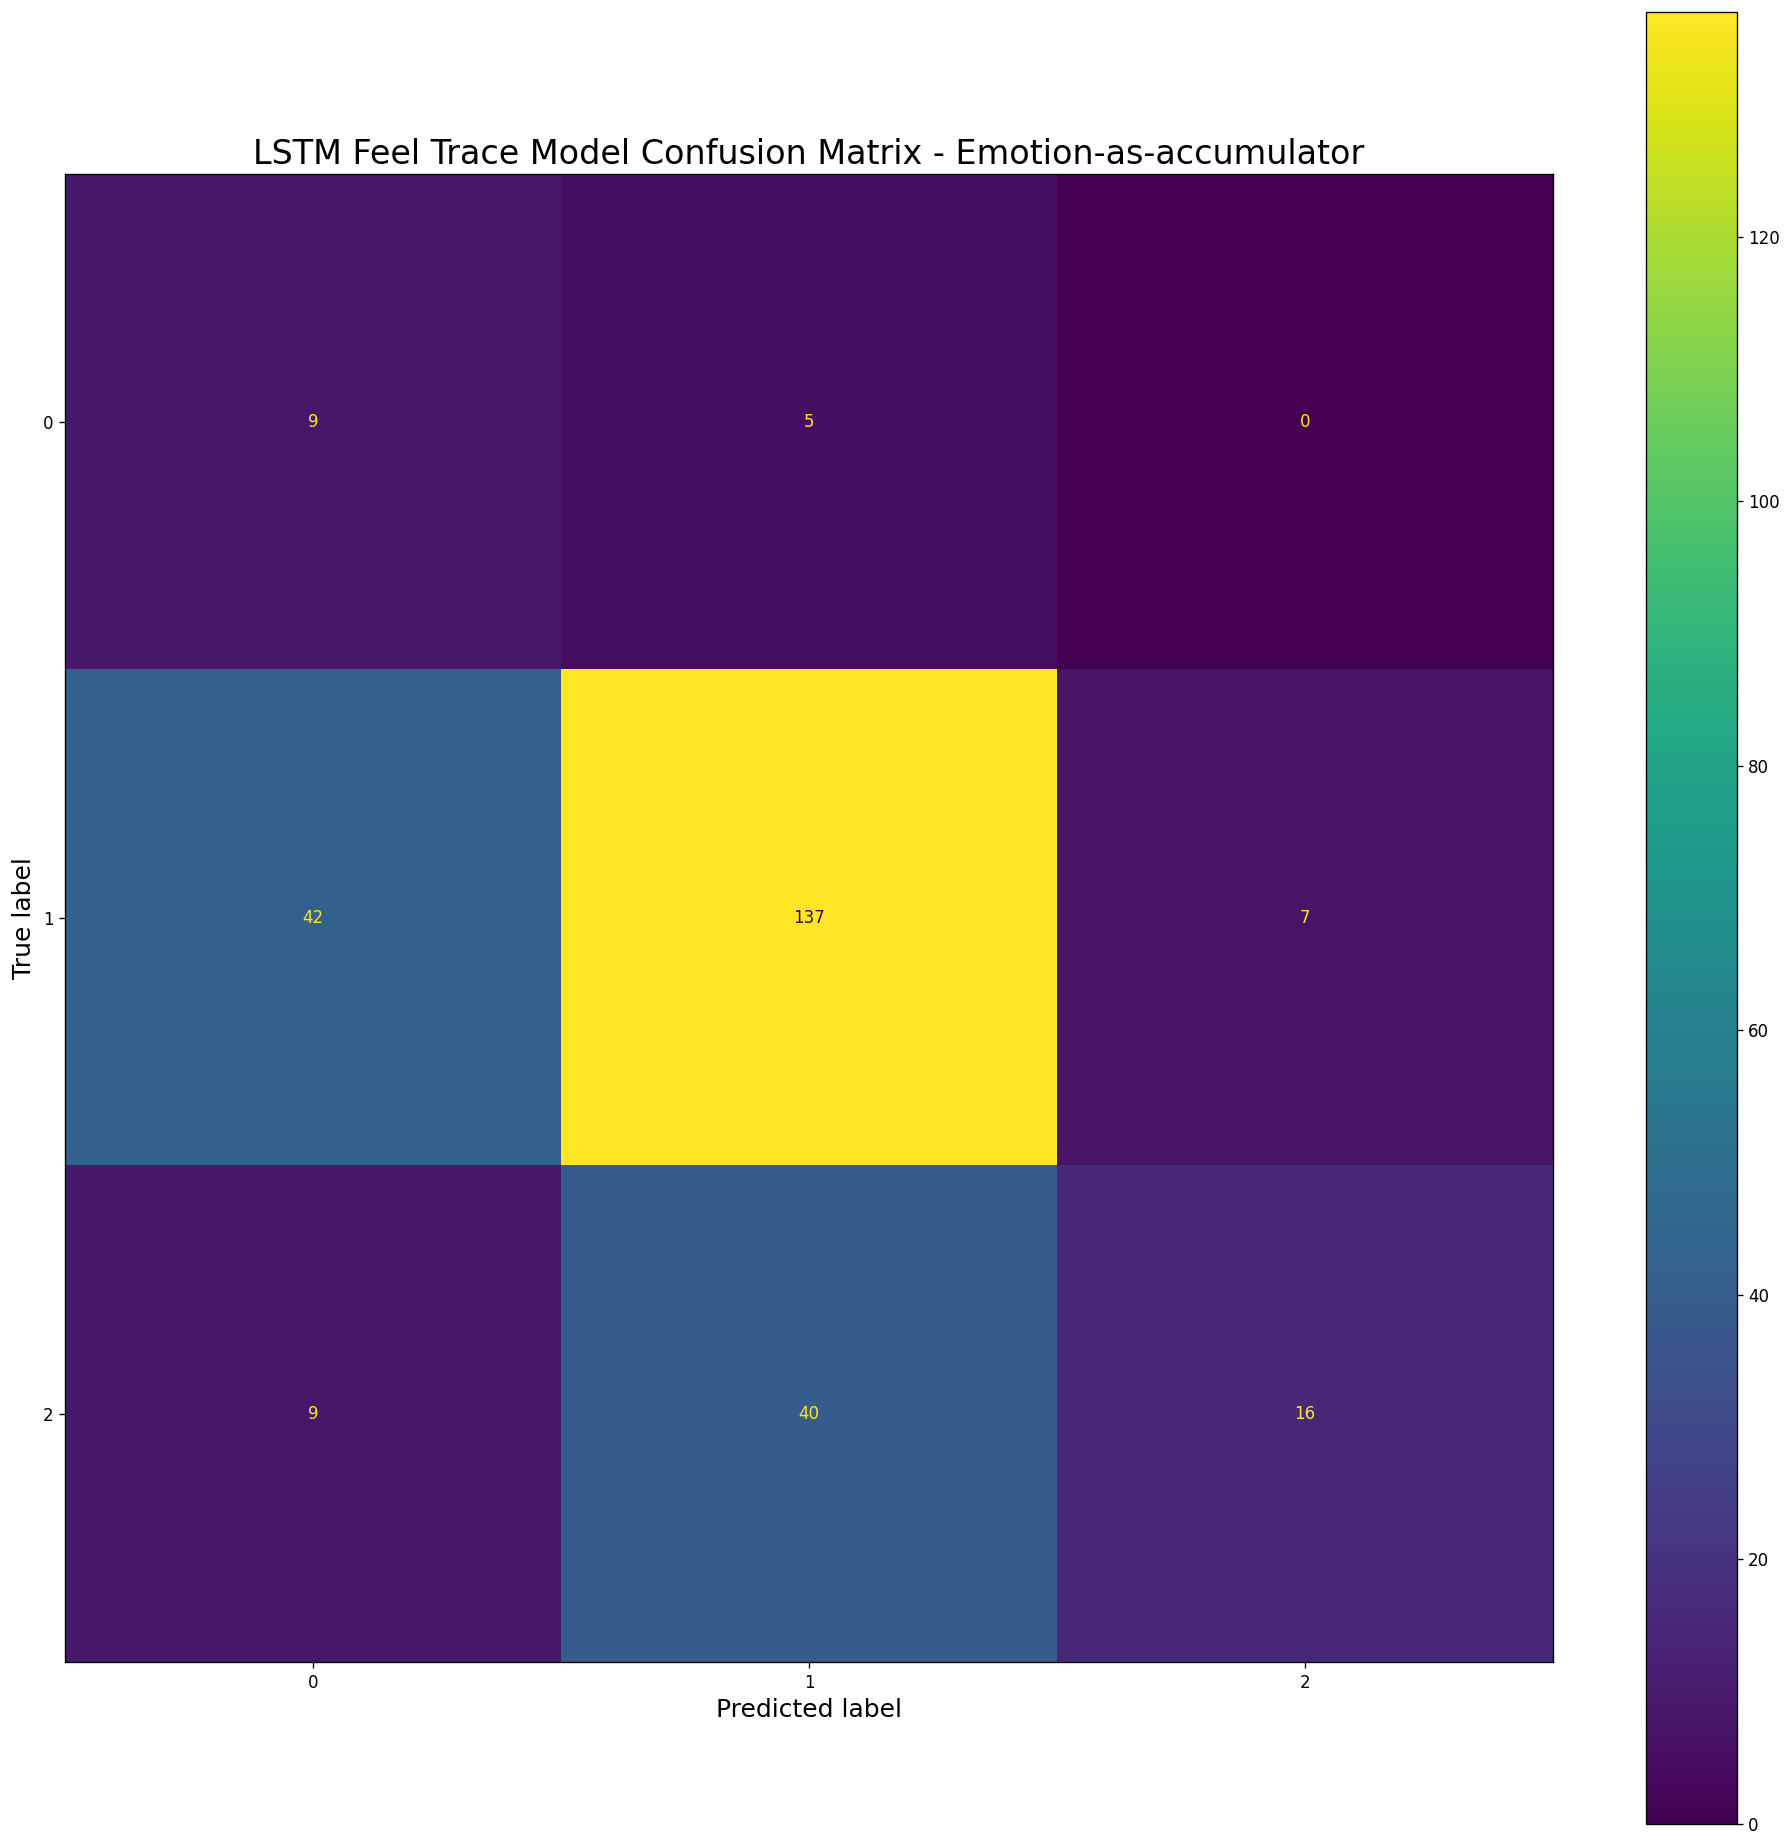

Training k=1
Training Classifier!
Train label distribution: [ 55 743 260]


100%|██████████| 9/9 [00:01<00:00,  5.20it/s]


Epoch:1,
Train Loss:1.7203491926193237,
Train Accuracy:0.335171568627451,
Train Recall: 0.33774102069176193,
Train precision: 0.1650235767201998,
Train F1-Score:0.20247635712469628,


100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


Epoch:2,
Train Loss:1.1247828006744385,
Train Accuracy:0.3927696078431373,
Train Recall: 0.3800054976987177,
Train precision: 0.34782532828452856,
Train F1-Score:0.26410414995409276,


100%|██████████| 9/9 [00:02<00:00,  3.45it/s]


Epoch:3,
Train Loss:1.046304702758789,
Train Accuracy:0.40778186274509803,
Train Recall: 0.4084279092450125,
Train precision: 0.48976884390907155,
Train F1-Score:0.314338871343461,


100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


Epoch:4,
Train Loss:0.9962623119354248,
Train Accuracy:0.5727124183006536,
Train Recall: 0.5420310068061714,
Train precision: 0.5663606756888775,
Train F1-Score:0.462776604083482,


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


Epoch:5,
Train Loss:0.9470754265785217,
Train Accuracy:0.5620915032679739,
Train Recall: 0.5593377013580296,
Train precision: 0.5363707493814136,
Train F1-Score:0.5235334871877892,


100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


Epoch:6,
Train Loss:0.8858511447906494,
Train Accuracy:0.5929330065359477,
Train Recall: 0.6002786835988018,
Train precision: 0.6021578542316244,
Train F1-Score:0.5722370057005031,


100%|██████████| 9/9 [00:02<00:00,  3.43it/s]


Epoch:7,
Train Loss:0.8714484572410583,
Train Accuracy:0.6024816176470588,
Train Recall: 0.6118947861325638,
Train precision: 0.6373534094716687,
Train F1-Score:0.5887480927448212,


100%|██████████| 9/9 [00:02<00:00,  3.41it/s]


Epoch:8,
Train Loss:0.8209269046783447,
Train Accuracy:0.6193321078431373,
Train Recall: 0.6230952437938382,
Train precision: 0.6240307699364919,
Train F1-Score:0.5960108293701961,


100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


Epoch:9,
Train Loss:0.784284770488739,
Train Accuracy:0.6504289215686274,
Train Recall: 0.6476818766235406,
Train precision: 0.6502684174669043,
Train F1-Score:0.6328277277910875,


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


Epoch:10,
Train Loss:0.7399265766143799,
Train Accuracy:0.685406454248366,
Train Recall: 0.6920912266398193,
Train precision: 0.6840088183967836,
Train F1-Score:0.6791714905687226,
Test label distribution: [ 14 186  65]
Precision: 0.3898030892424022
Recall: 0.40338335499625827
F1-Score: 0.3895911997312151
Base line F1-Score: 0.2749445676274945
Accuracy: 0.569811320754717
Metrics:
              precision    recall  f1-score   support

           0       0.10      0.21      0.14        14
           1       0.72      0.69      0.70       186
           2       0.35      0.31      0.33        65

    accuracy                           0.57       265
   macro avg       0.39      0.40      0.39       265
weighted avg       0.59      0.57      0.58       265



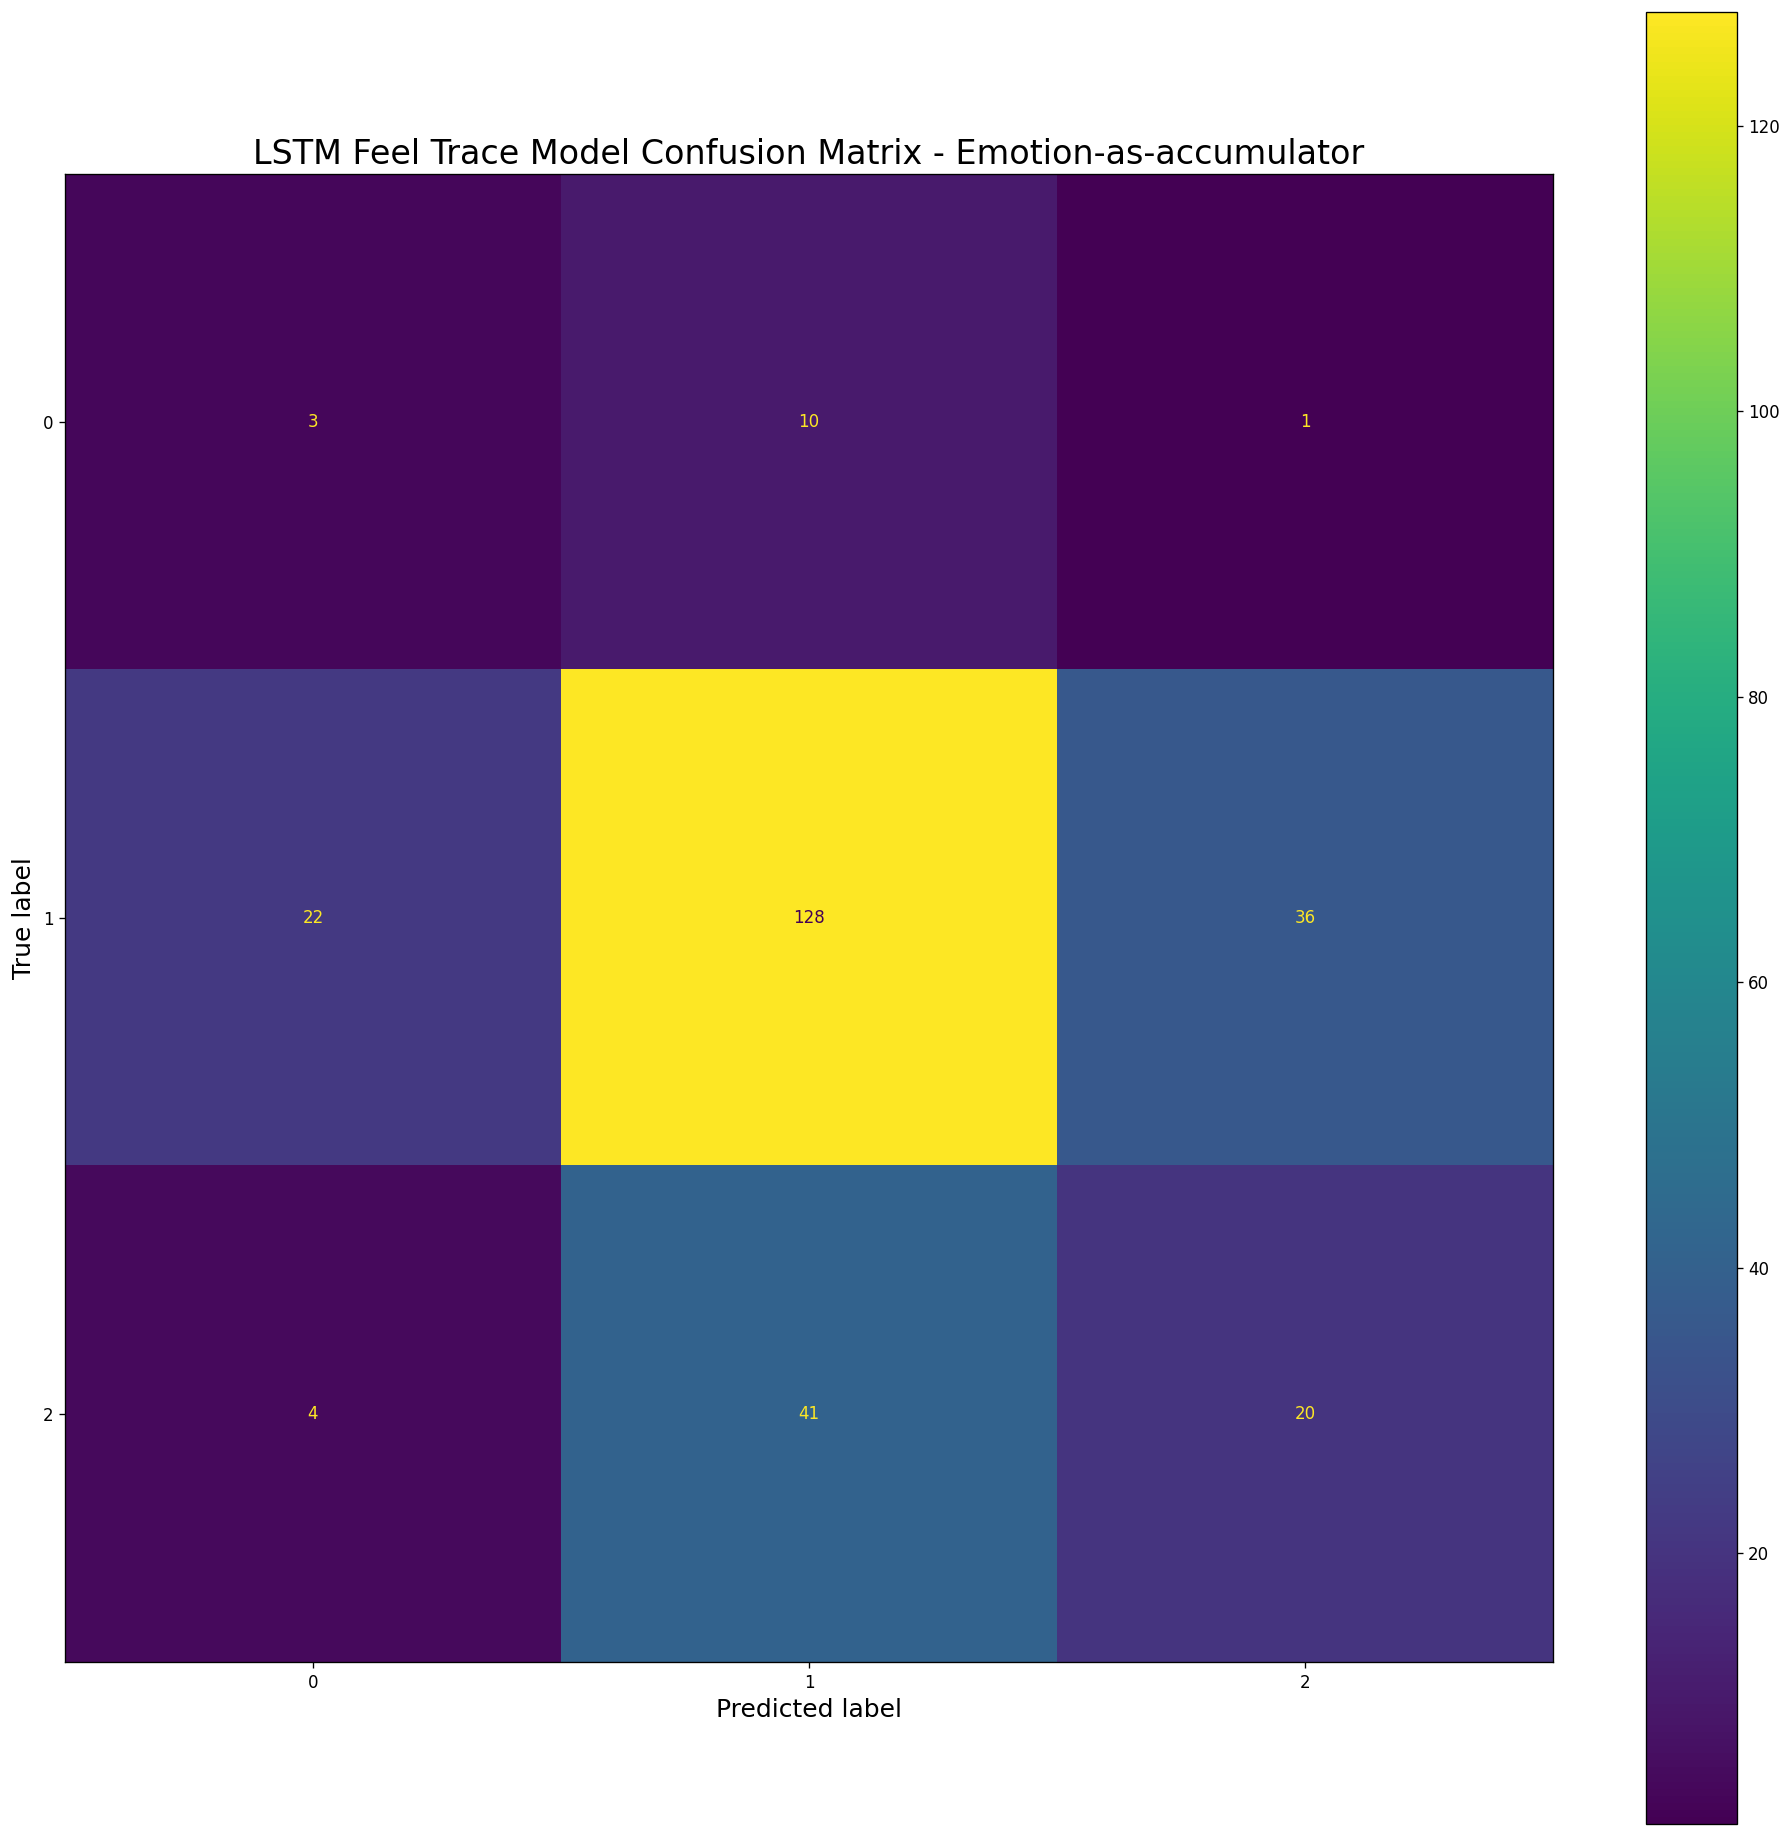

Training k=2
Training Classifier!
Train label distribution: [ 55 743 260]


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


Epoch:1,
Train Loss:1.3448759317398071,
Train Accuracy:0.3576388888888889,
Train Recall: 0.3591828439576236,
Train precision: 0.2348715559898084,
Train F1-Score:0.25980168255307745,


100%|██████████| 9/9 [00:02<00:00,  3.31it/s]


Epoch:2,
Train Loss:1.0361933708190918,
Train Accuracy:0.4427083333333333,
Train Recall: 0.44692323318823957,
Train precision: 0.4991739783188945,
Train F1-Score:0.3661553877438767,


100%|██████████| 9/9 [00:02<00:00,  3.39it/s]


Epoch:3,
Train Loss:0.9323613047599792,
Train Accuracy:0.5488664215686274,
Train Recall: 0.5620235113698472,
Train precision: 0.5777776519183149,
Train F1-Score:0.5264620987894879,


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


Epoch:4,
Train Loss:0.8670486807823181,
Train Accuracy:0.5810355392156863,
Train Recall: 0.5915341430478019,
Train precision: 0.5837279246248932,
Train F1-Score:0.5764377750427552,


100%|██████████| 9/9 [00:02<00:00,  3.24it/s]


Epoch:5,
Train Loss:0.8309693932533264,
Train Accuracy:0.6168300653594772,
Train Recall: 0.6141564318987547,
Train precision: 0.622168537031666,
Train F1-Score:0.5967795421285701,


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


Epoch:6,
Train Loss:0.7748613953590393,
Train Accuracy:0.6481311274509803,
Train Recall: 0.6452574318247775,
Train precision: 0.660213731346371,
Train F1-Score:0.634733200255361,


100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


Epoch:7,
Train Loss:0.7550170421600342,
Train Accuracy:0.671109068627451,
Train Recall: 0.6668682831425377,
Train precision: 0.6696731278755865,
Train F1-Score:0.6538932260355813,


100%|██████████| 9/9 [00:02<00:00,  3.29it/s]


Epoch:8,
Train Loss:0.7489171028137207,
Train Accuracy:0.6631944444444444,
Train Recall: 0.6676790476620815,
Train precision: 0.6678178002560886,
Train F1-Score:0.6526976429448891,


100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


Epoch:9,
Train Loss:0.7224396467208862,
Train Accuracy:0.6893382352941176,
Train Recall: 0.6910984939362633,
Train precision: 0.696330975636818,
Train F1-Score:0.6695153687270116,


100%|██████████| 9/9 [00:02<00:00,  3.45it/s]


Epoch:10,
Train Loss:0.6937680840492249,
Train Accuracy:0.6801981209150327,
Train Recall: 0.6780500586732379,
Train precision: 0.6649803480698954,
Train F1-Score:0.6603566261955189,
Test label distribution: [ 14 186  65]
Precision: 0.3981005553586199
Recall: 0.45082516050257987
F1-Score: 0.3732304431703937
Base line F1-Score: 0.2749445676274945
Accuracy: 0.46037735849056605
Metrics:
              precision    recall  f1-score   support

           0       0.10      0.43      0.16        14
           1       0.77      0.46      0.58       186
           2       0.33      0.46      0.38        65

    accuracy                           0.46       265
   macro avg       0.40      0.45      0.37       265
weighted avg       0.62      0.46      0.51       265



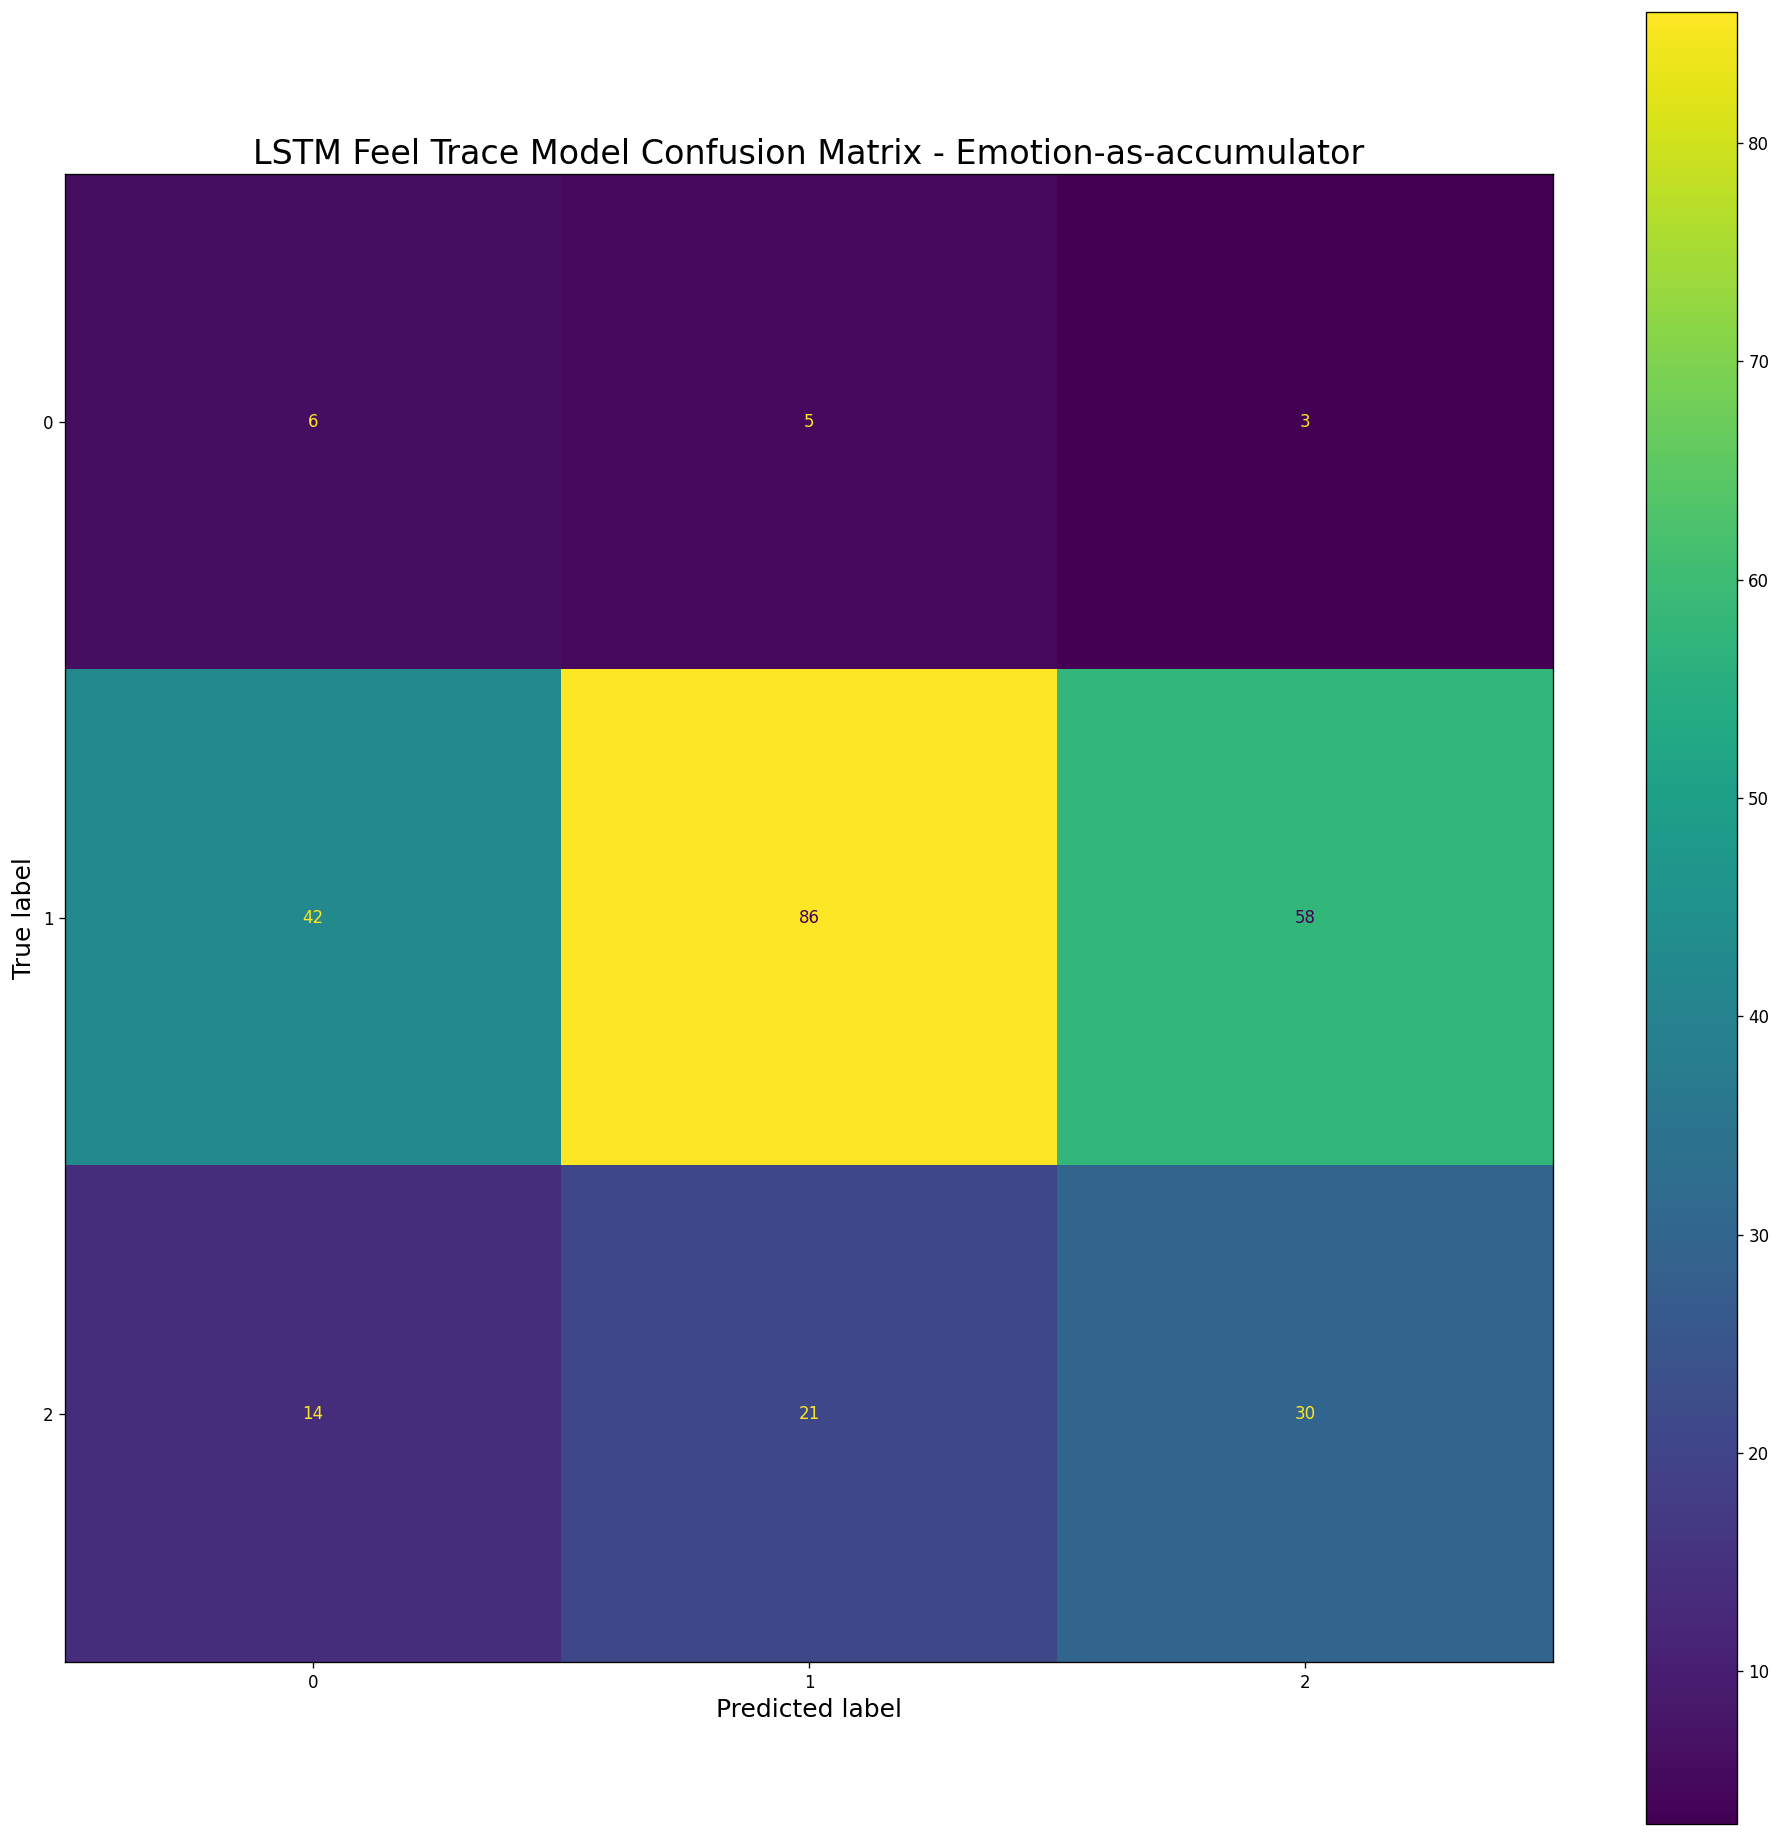

Training k=3
Training Classifier!
Train label distribution: [ 56 743 260]


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


Epoch:1,
Train Loss:1.2958447933197021,
Train Accuracy:0.33035714285714285,
Train Recall: 0.33693591025736097,
Train precision: 0.27983526233814915,
Train F1-Score:0.20165890197434166,


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


Epoch:2,
Train Loss:1.0417240858078003,
Train Accuracy:0.4833829365079365,
Train Recall: 0.48649112449194537,
Train precision: 0.4964916521587399,
Train F1-Score:0.42570925357797856,


100%|██████████| 9/9 [00:02<00:00,  3.50it/s]


Epoch:3,
Train Loss:0.9773712158203125,
Train Accuracy:0.4989335317460318,
Train Recall: 0.49555588826656943,
Train precision: 0.5823143166551737,
Train F1-Score:0.4663895000732764,


100%|██████████| 9/9 [00:02<00:00,  3.29it/s]


Epoch:4,
Train Loss:0.8828046321868896,
Train Accuracy:0.6204861111111111,
Train Recall: 0.6218455866414517,
Train precision: 0.6168436468390722,
Train F1-Score:0.6008797374621434,


100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


Epoch:5,
Train Loss:0.8546726107597351,
Train Accuracy:0.6049107142857143,
Train Recall: 0.608403534810349,
Train precision: 0.6094402689678774,
Train F1-Score:0.5900652917072344,


100%|██████████| 9/9 [00:02<00:00,  3.39it/s]


Epoch:6,
Train Loss:0.8103468418121338,
Train Accuracy:0.6393105158730159,
Train Recall: 0.6521884790814414,
Train precision: 0.6463822877387972,
Train F1-Score:0.6356172458764678,


100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


Epoch:7,
Train Loss:0.7833187580108643,
Train Accuracy:0.6471230158730159,
Train Recall: 0.6455862910794514,
Train precision: 0.6471150407396807,
Train F1-Score:0.6302459331928462,


100%|██████████| 9/9 [00:02<00:00,  3.35it/s]


Epoch:8,
Train Loss:0.737434446811676,
Train Accuracy:0.692485119047619,
Train Recall: 0.6927409309780673,
Train precision: 0.6944700826399905,
Train F1-Score:0.6826182209656976,


100%|██████████| 9/9 [00:02<00:00,  3.38it/s]


Epoch:9,
Train Loss:0.6958099603652954,
Train Accuracy:0.7193948412698412,
Train Recall: 0.7120496400532241,
Train precision: 0.7177745416518734,
Train F1-Score:0.7007665840070234,


100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


Epoch:10,
Train Loss:0.6909818649291992,
Train Accuracy:0.7055059523809524,
Train Recall: 0.7093529820817964,
Train precision: 0.7218462692528028,
Train F1-Score:0.6895044784202827,
Test label distribution: [ 13 186  65]
Precision: 0.3964844262708869
Recall: 0.4487730907085746
F1-Score: 0.3513444739251191
Base line F1-Score: 0.27555555555555555
Accuracy: 0.42045454545454547
Metrics:
              precision    recall  f1-score   support

           0       0.08      0.46      0.14        13
           1       0.78      0.39      0.52       186
           2       0.32      0.49      0.39        65

    accuracy                           0.42       264
   macro avg       0.40      0.45      0.35       264
weighted avg       0.64      0.42      0.47       264



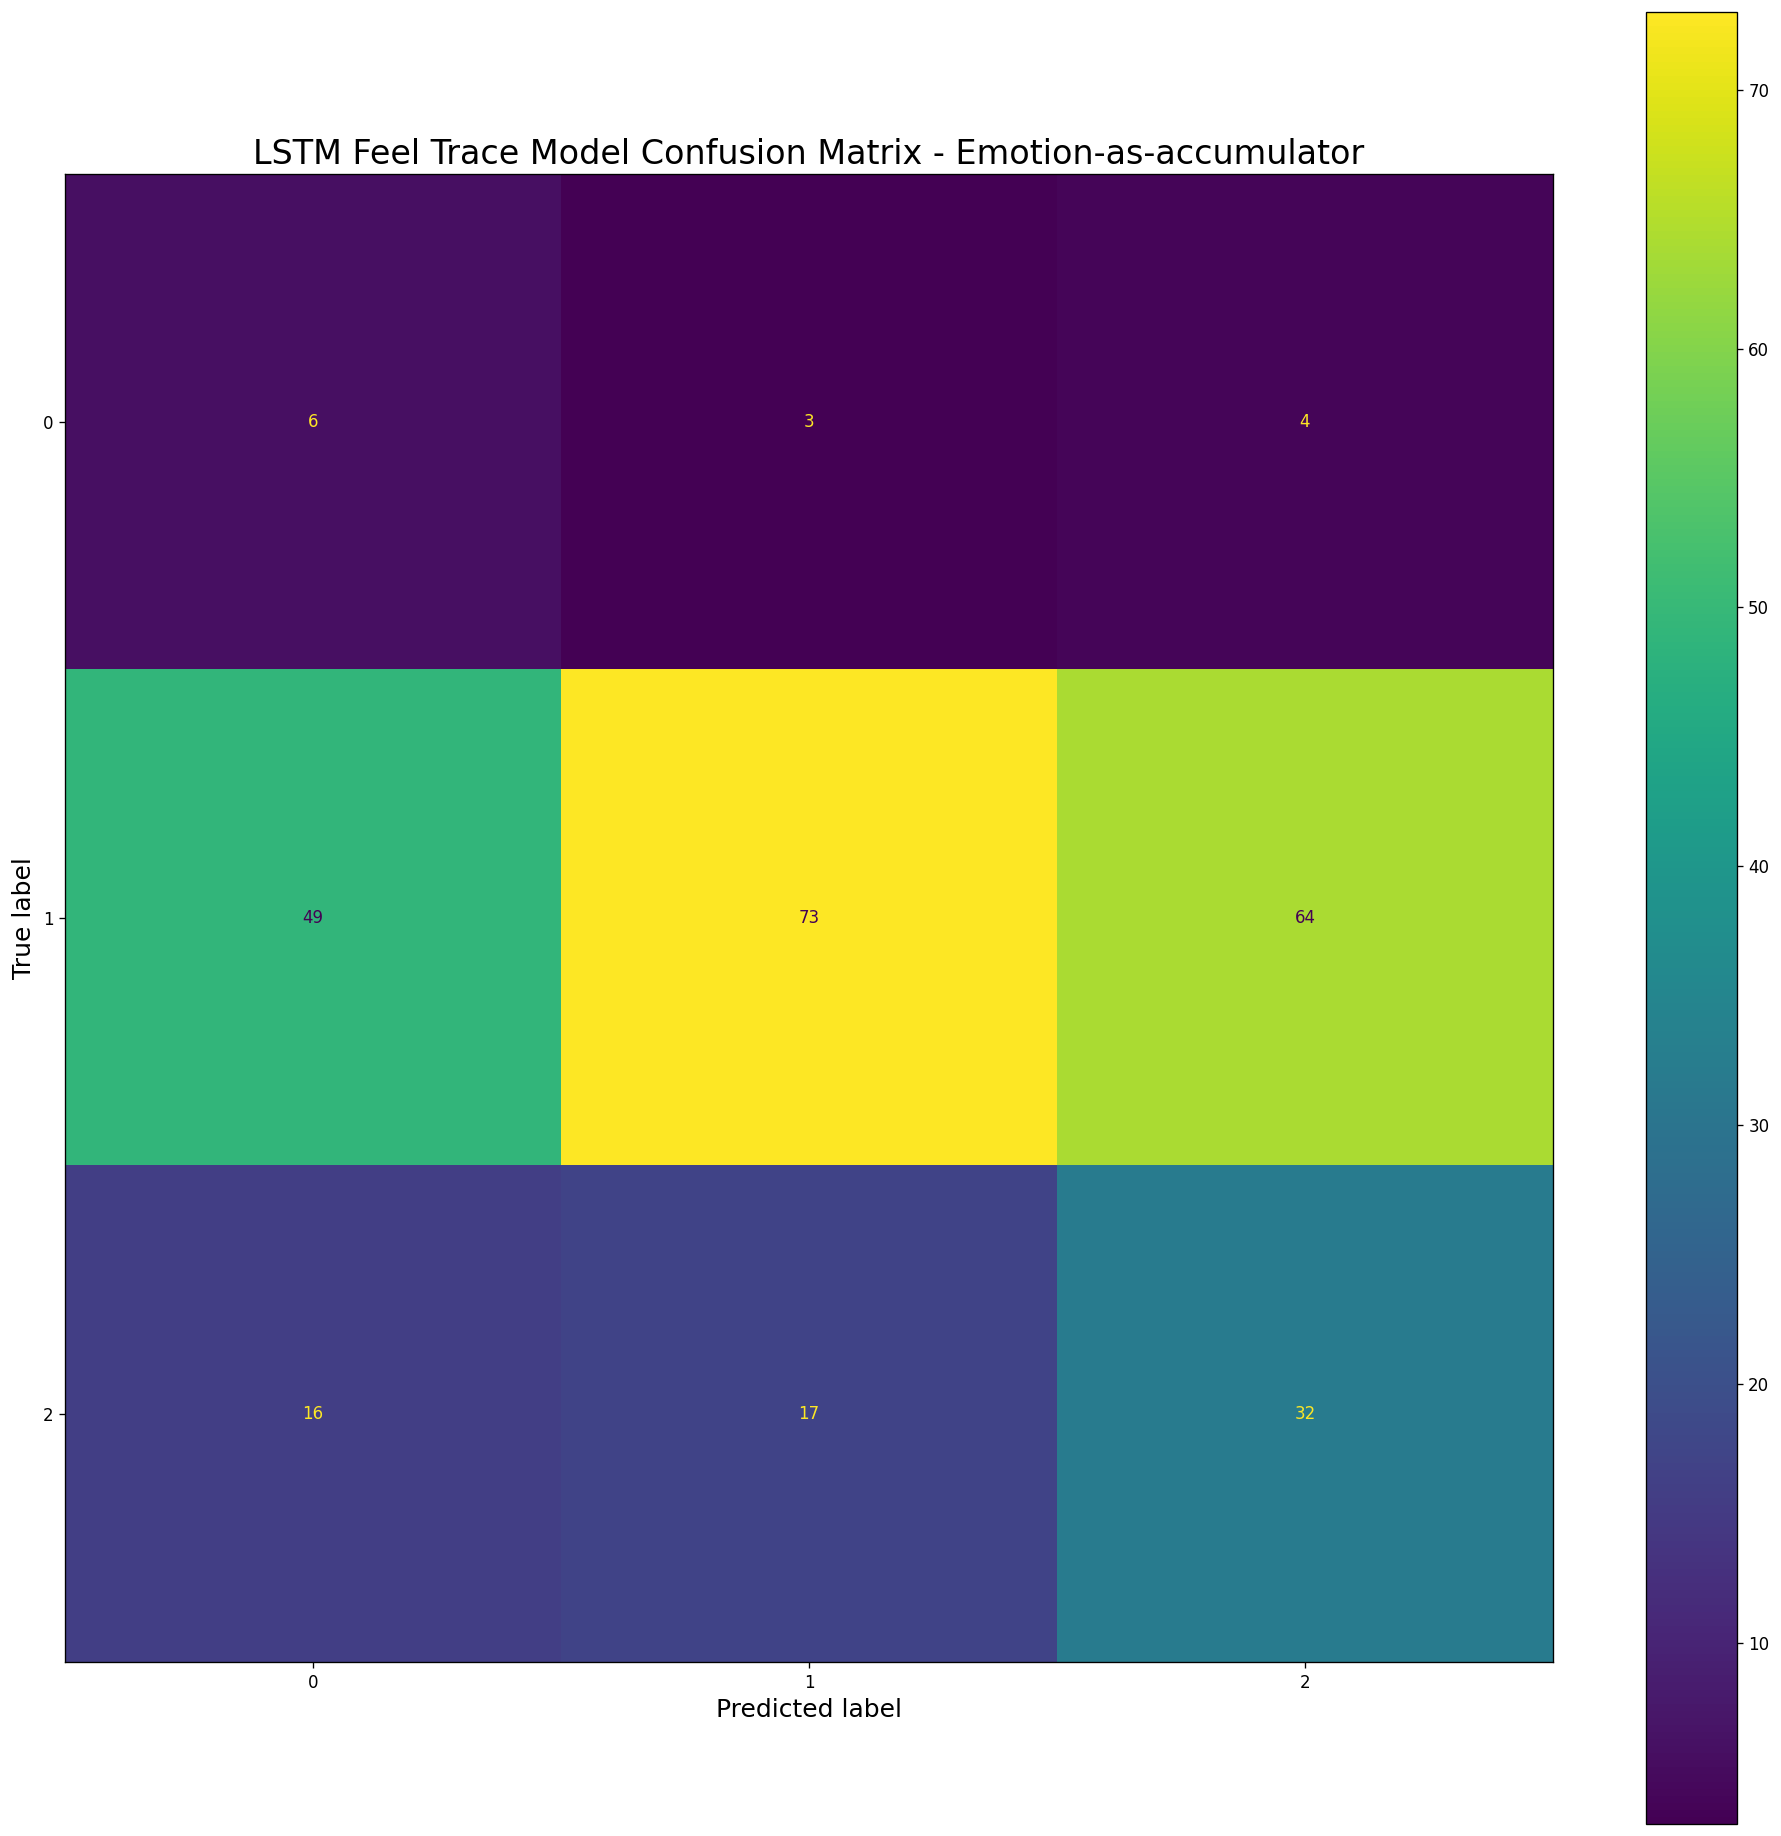

Training k=4
Training Classifier!
Train label distribution: [ 55 744 260]


100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


Epoch:1,
Train Loss:1.239896297454834,
Train Accuracy:0.37837301587301586,
Train Recall: 0.3805132425152264,
Train precision: 0.3027788447866453,
Train F1-Score:0.2885953774762862,


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


Epoch:2,
Train Loss:0.9822711944580078,
Train Accuracy:0.4998015873015873,
Train Recall: 0.475948120483885,
Train precision: 0.5341143946771896,
Train F1-Score:0.4114832983734842,


100%|██████████| 9/9 [00:02<00:00,  3.13it/s]


Epoch:3,
Train Loss:0.9059025645256042,
Train Accuracy:0.5640873015873016,
Train Recall: 0.5660542658353124,
Train precision: 0.5727560156591684,
Train F1-Score:0.5446287044949413,


100%|██████████| 9/9 [00:02<00:00,  3.51it/s]


Epoch:4,
Train Loss:0.8533945679664612,
Train Accuracy:0.5880952380952381,
Train Recall: 0.5806091314949351,
Train precision: 0.6182031031560079,
Train F1-Score:0.5607904189799894,


100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


Epoch:5,
Train Loss:0.8229798078536987,
Train Accuracy:0.6297371031746031,
Train Recall: 0.6384504410417458,
Train precision: 0.6397715824895669,
Train F1-Score:0.6240083103248691,


100%|██████████| 9/9 [00:02<00:00,  3.31it/s]


Epoch:6,
Train Loss:0.7747398018836975,
Train Accuracy:0.6603918650793651,
Train Recall: 0.6541054275273539,
Train precision: 0.6768748871084388,
Train F1-Score:0.6375276591645691,


100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


Epoch:7,
Train Loss:0.7442423701286316,
Train Accuracy:0.684970238095238,
Train Recall: 0.6816409250761439,
Train precision: 0.6902793248267987,
Train F1-Score:0.6766971034767543,


100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


Epoch:8,
Train Loss:0.735952615737915,
Train Accuracy:0.6855654761904763,
Train Recall: 0.6887010613260892,
Train precision: 0.7088957601923211,
Train F1-Score:0.6762918982786333,


100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


Epoch:9,
Train Loss:0.7407256960868835,
Train Accuracy:0.667063492063492,
Train Recall: 0.6791608071581673,
Train precision: 0.6895557578159541,
Train F1-Score:0.6551660179523091,


100%|██████████| 9/9 [00:02<00:00,  3.36it/s]


Epoch:10,
Train Loss:0.6911591291427612,
Train Accuracy:0.7087053571428572,
Train Recall: 0.7087096481324893,
Train precision: 0.7147000931922056,
Train F1-Score:0.69755690937208,
Test label distribution: [ 14 185  65]
Precision: 0.39648526077097507
Recall: 0.41033561033561033
F1-Score: 0.3818083827289569
Base line F1-Score: 0.27468448403860435
Accuracy: 0.5113636363636364
Metrics:
              precision    recall  f1-score   support

           0       0.05      0.14      0.07        14
           1       0.76      0.52      0.62       185
           2       0.38      0.57      0.45        65

    accuracy                           0.51       264
   macro avg       0.40      0.41      0.38       264
weighted avg       0.63      0.51      0.55       264



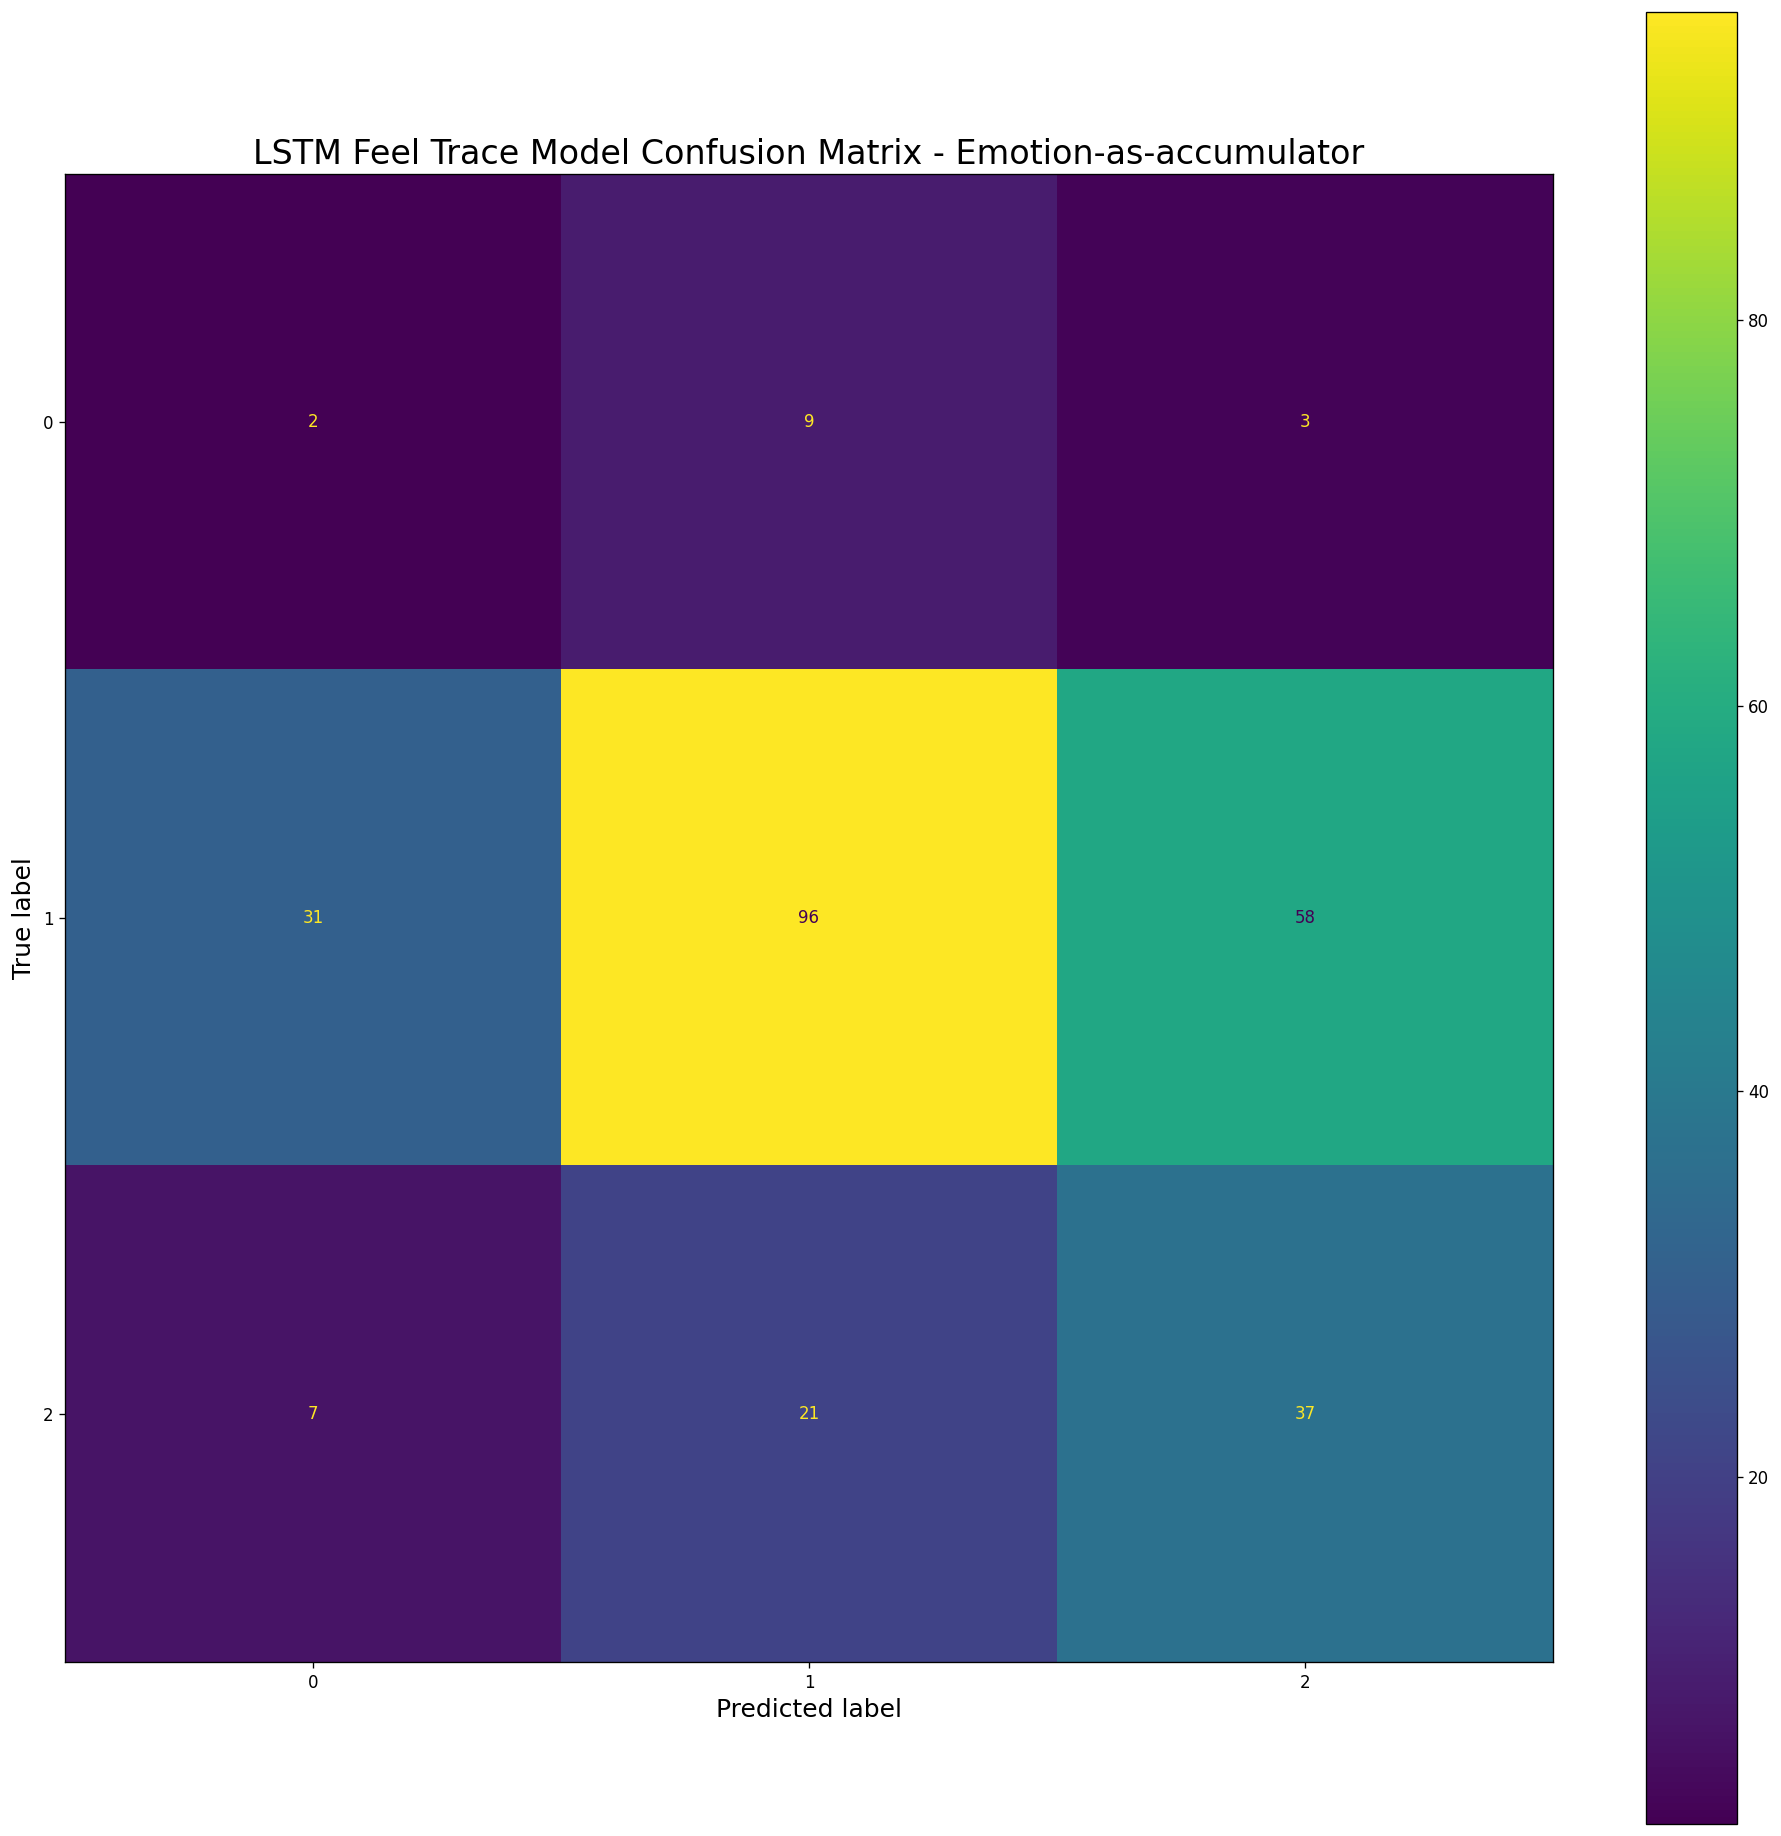

Accuracy, Average accuracy: [0.6113207547169811, 0.569811320754717, 0.46037735849056605, 0.42045454545454547, 0.5113636363636364], 0.5146655231560892
F1-Score, Average F1-Score: [0.45048160809030374, 0.3895911997312151, 0.3732304431703937, 0.3513444739251191, 0.3818083827289569], 0.3892912215291977


In [10]:
k_acc = [] # accuracies for each fold
k_f1 = [] # f1 score for each fold

for cur_k in range(len(indices)):
    print(f"Training k={cur_k}")
    train_index, test_index = indices[cur_k]

    classifier_model = classifier(num_features=num_features, num_hidden=classifier_hidden, dropout=0.8, n_labels=num_classes)


    encoded_train_features = dataset[train_index]
    print('Training Classifier!')
    classifier_train_metrics = train_classifier(classifier_model, classifier_train_epochs, batch_size=128, learning_rate=classifier_learning_rate, features=encoded_train_features, labels=labels[train_index])


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_features, test_labels =  dataset[test_index], labels[test_index]
    print(f"Test label distribution: {np.bincount(test_labels, minlength=num_classes)}")
    encoded_test_features = test_features

    with torch.no_grad():
        classifier_model.eval()
        x_encoded  = torch.from_numpy(encoded_test_features).float().to(device)
        y = test_labels
        y_hat = classifier_model(x_encoded)
        y_hat = F.softmax(y_hat.detach(), dim=-1).cpu().numpy()
        preds = y_hat

    fig, axs = plt.subplots(figsize=(20,20), dpi=120)
    axs.set_title(f"LSTM Feel Trace Model Confusion Matrix - Emotion-as-{label_type}", fontsize=20)
    axs.set_xlabel("Predicted Label", fontsize=15)
    axs.set_ylabel("True Label", fontsize=15)


    prf = precision_recall_fscore_support(test_labels, np.array([x.argmax() for x in preds]), average='macro', zero_division=0)
    base_line = precision_recall_fscore_support(test_labels, np.array([1 for x in preds]), average='macro', zero_division=0)
    acc = np.mean(test_labels == np.array([x.argmax() for x in preds]))

    print(f"Precision: {prf[0]}")
    print(f"Recall: {prf[1]}")
    print(f"F1-Score: {prf[2]}")
    print(f"Base line F1-Score: {base_line[2]}")
    print(f"Accuracy: {acc}")
    print('Metrics:')
    print(classification_report(test_labels, np.array([x.argmax() for x in preds])))

    k_acc.append(acc)
    k_f1.append(prf[2])

    cm = confusion_matrix(test_labels, [x.argmax() for x in preds], labels=np.arange(num_classes), normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))

    disp.plot(ax=axs)
    plt.show()

print(f"Accuracy, Average accuracy: {k_acc}, {np.mean(k_acc)}")
print(f"F1-Score, Average F1-Score: {k_f1}, {np.mean(k_f1)}")